In [ ]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-SAM-2.git

%cd /content/Grounded-SAM-2/checkpoints
!bash download_ckpts.sh

%cd /content/Grounded-SAM-2/gdino_checkpoints
!bash download_ckpts.sh

In [ ]:
%cd /content/Grounded-SAM-2
!pip install -e .

In [3]:
%cd /content/Grounded-SAM-2
!pip install --no-build-isolation -e grounding_dino

/content/Grounded-SAM-2
Obtaining file:///content/Grounded-SAM-2/grounding_dino
  Preparing metadata (setup.py) ... done
  Running setup.py develop for groundingdino


In [ ]:
!pip install supervision
!pip install addict
!pip install yapf

In [5]:
import os
import cv2
import json
import torch
import numpy as np
import supervision as sv
import pycocotools.mask as mask_util
from pathlib import Path
from torchvision.ops import box_convert
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict

In [6]:
"""
Hyper parameters
"""
TEXT_PROMPT = "car. tire."
IMG_PATH = "notebooks/images/truck.jpg"
SAM2_CHECKPOINT = "./checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = Path("outputs/grounded_sam2_local_demo")
DUMP_JSON_RESULTS = True

# create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# environment settings
# use bfloat16

# build SAM2 image predictor
sam2_checkpoint = SAM2_CHECKPOINT
model_cfg = SAM2_MODEL_CONFIG
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
# build grounding dino model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

# setup the input image and text prompt for SAM 2 and Grounding DINO
# VERY important: text queries need to be lowercased + end with a dot
text = TEXT_PROMPT
img_path = IMG_PATH

image_source, image = load_image(img_path)

sam2_predictor.set_image(image_source)

In [8]:
boxes, confidences, labels = predict(
    model=grounding_model,
    image=image,
    caption=text,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE
)

# process the box prompt for SAM 2
h, w, _ = image_source.shape
boxes = boxes * torch.Tensor([w, h, w, h])
input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

In [9]:
# FIXME: figure how does this influence the G-DINO model
torch.autocast(device_type=DEVICE, dtype=torch.bfloat16).__enter__()

if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

masks, scores, logits = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [10]:
"""
Post-process the output of the model to get the masks, scores, and logits for visualization
"""
# convert the shape to (n, H, W)
if masks.ndim == 4:
    masks = masks.squeeze(1)

confidences = confidences.numpy().tolist()
class_names = labels

class_ids = np.array(list(range(len(class_names))))

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(class_names, confidences)
]

In [11]:
"""
Visualize image with supervision useful API
"""
img = cv2.imread(img_path)
detections = sv.Detections(
    xyxy=input_boxes,  # (n, 4)
    mask=masks.astype(bool),  # (n, h, w)
    class_id=class_ids
)

box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

label_annotator = sv.LabelAnnotator()
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
cv2.imwrite(os.path.join(OUTPUT_DIR, "groundingdino_annotated_image.jpg"), annotated_frame)

mask_annotator = sv.MaskAnnotator()
annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
cv2.imwrite(os.path.join(OUTPUT_DIR, "grounded_sam2_annotated_image_with_mask.jpg"), annotated_frame)


True

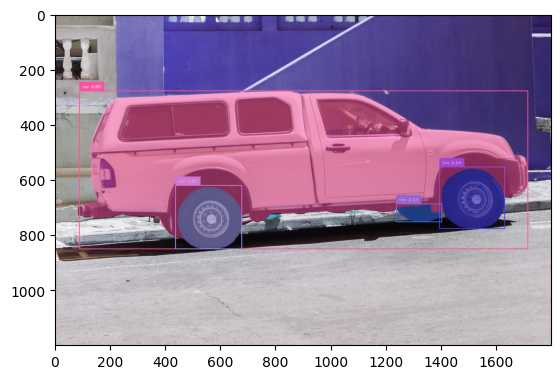

In [12]:
import matplotlib.pyplot as plt

plt.imshow(annotated_frame)

In [13]:

"""
Dump the results in standard format and save as json files
"""

def single_mask_to_rle(mask):
    rle = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

if DUMP_JSON_RESULTS:
    # convert mask into rle format
    mask_rles = [single_mask_to_rle(mask) for mask in masks]

    input_boxes = input_boxes.tolist()
    scores = scores.tolist()
    # save the results in standard format
    results = {
        "image_path": img_path,
        "annotations" : [
            {
                "class_name": class_name,
                "bbox": box,
                "segmentation": mask_rle,
                "score": score,
            }
            for class_name, box, mask_rle, score in zip(class_names, input_boxes, mask_rles, scores)
        ],
        "box_format": "xyxy",
        "img_width": w,
        "img_height": h,
    }

    with open(os.path.join(OUTPUT_DIR, "grounded_sam2_local_image_demo_results.json"), "w") as f:
        json.dump(results, f, indent=4)